In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from scipy.optimize import minimize
import functools

r = 0.04
beta = 0.98
Y = np.array([[40000, 50000]]*40 + [[0, 0]]*20)

Problem 1
----------
The FOCs for $c_t^A$, $c_t^B$ and $Q_t$ imply that
\begin{align}
\frac{\beta^{t-1}}{5c_t^A} & = \gamma_t, \quad \forall t, \quad \text{ when } c_t^A > 0 \\
\frac{\beta^{t-1}}{5c_t^B} & = \gamma_t, \quad \forall t, \quad \text{ when } c_t^B > 0\\
\frac{3\beta^{t-1}}{5Q_t} & = \gamma_t, \quad \forall t, \quad \text{ when } Q_t > 0 \\
\end{align}
so that $c_t^A = c_t^B$ and $Q_t = 3c_t^A$. Finally, the FOC for $A_{t+1}$ imply $\gamma_t = \gamma_{t+1}(1+r)$ so that $c_{t+1}^A(1+r)\beta = c_t^A$, $c_{t+1}^B(1+r)\beta = c_t^B$, and $Q_{t+1}(1+r)\beta = Q_t$. We know these quantities are strictly positive because we have infinite marginal utility at 0. Finally, we must exhaust resources at $T+1$ in any optimum, so that $A_{T+1}=0$. Given these conditions we need only guess $c_0^A$ and iterate through the resource constraint over the lifetime until $A_{T+1}=0$. 

True 10549.4308427


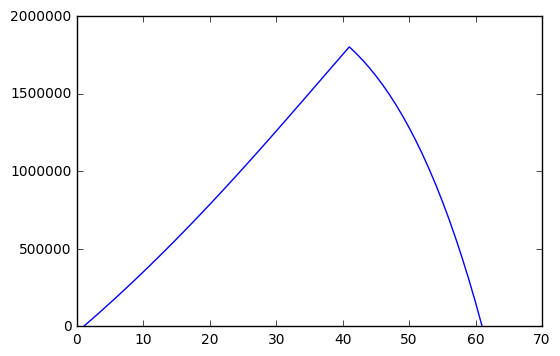

In [2]:
def asset_profile1(ca0):
    
    A = np.zeros(61)

    cb0 = ca0
    Q0 = 3*ca0
    A_pre = 0
    for t in range(60):
        A_next = (1 + r)*A_pre + Y[t].sum() - (ca0 + cb0 + Q0)*((1 + r)*beta)**t
        A_pre = A_next

        A[t+1] = A_next
    
    return A

def term_cond1(ca0):
    
    return abs(asset_profile1(ca0)[-1])

rslt = minimize(term_cond1, x0=1000, method='Nelder-Mead')
print(rslt.success, rslt.x[0])
plt.plot(range(1, 62), asset_profile1(rslt.x[0]))

Problem 2
----------
Now we have the following FOCs for $c_t^A$, $c_t^B$ and $Q_t$:
\begin{align}
\frac{2\theta\beta^{t-1}}{5c_t^A} & = \gamma_t, \quad \forall t, \quad \text{ when } c_t^A > 0 \\
\frac{(1-\theta)\beta^{t-1}}{5c_t^B} & = \gamma_t, \quad \forall t, \quad \text{ when } c_t^B > 0 \\
\frac{3\beta^{t-1}}{5Q_t} & = \gamma_t, \quad \forall t, \quad \text{ when } Q_t > 0,
\end{align}
so that $c_t^B = \frac{(1-\theta)}{2\theta}c_t^A$ and $Q_t = \frac{3}{2\theta}c_t^A$. The logic of the previous problem follows and we can solve using the same algorithm.

True 7360.06802917
True 11721.5898255
True 15711.9182765


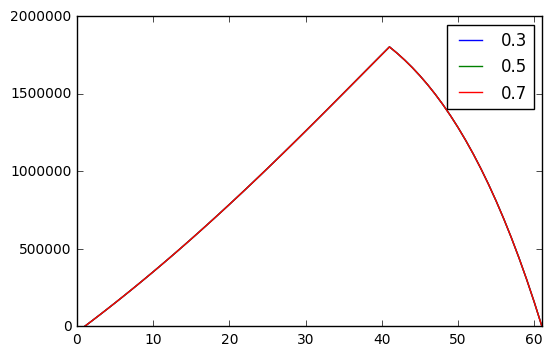

In [3]:
def asset_profile2(theta, ca0):
    
    A = np.zeros(61)
    
    cb0 = (1-theta)*ca0/(2*theta)
    Q0 = 3*ca0/(2*theta)
    A_pre = 0
    for t in range(60):
        A_next = (1 + r)*A_pre + Y[t].sum() - (ca0 + cb0 + Q0)*((1 + r)*beta)**t
        A_pre = A_next

        A[t+1] = A_next
    
    return A

def term_cond2(theta, ca0):
    
    return abs(asset_profile2(theta, ca0)[-1])

thetas = [0.3, 0.5, 0.7]
A = pd.DataFrame(columns=thetas)

for theta in thetas:
    
    eval_term_cond = functools.partial(term_cond2, theta)
    
    rslt = minimize(eval_term_cond, x0=1000, method='Nelder-Mead')
    print(rslt.success, rslt.x[0])
    A[theta] = asset_profile2(theta, rslt.x[0])
    
A.index = range(1, 62)
A.plot(xlim=[0, 61], ylim=[0, 2000000])

As we can see, we obtain the same path for assets across different values of $\theta$. The only changes will be that the within-period distribution of income between A and B will change with $\theta$.

Problem 3
----------
It will be helpful to write the problem recursively.
\begin{align}
V_t(A_t,S_t^A,S_t^B) & = \max_{q_t} \; u_t(c_t^A,c_t^B,Q_t,S_t^A,S_t^B) + 
\beta\sum_{S'}P_{S'|S}^{t+1}V_{t+1}(A_{t+1},S')
\end{align}
where $S_t^i\in \{0,1\}$ denotes if individual $i$ survived to age $t$, and $S$ is shorthand for today's state of survival and $S'$ for the future state. Additionally, $P_{S'|S}^{t+1}$ is the probability of going from state $S$ to $S'$. We can also write
\begin{align}
u_t(c_t^A,c_t^B,Q_t,S_t^A,S_t^B) =
    \begin{cases}
    a\theta\ln c_t^A + b(1-\theta)\ln c_t^B + d\ln Q_t & \text{ if } S_t^A=S_t^B=1 \\
    a\ln c_t^A + d\ln Q_t & \text{ if } S_t^A=1,S_t^B=0 \\
    b\ln c_t^B + d\ln Q_t & \text{ if } S_t^A=0,S_t^B=1 \\
    0 & \text{ if } S_t^A=S_t^B=0.
    \end{cases}
\end{align}
Using the FOCs for $c_t^B$, $c_t^A$, and $Q_t$, we can write $c_t^A$ and $c_t^B$ as functions of $Q_t$ for each period:
\begin{align}
    \begin{cases}
    c_t^A=\frac{a\theta}{d}Q_t,\; c_t^B=\frac{b(1-\theta)}{d}Q_t & \text{ if } S_t^A=S_t^B=1 \\
    c_t^B=0,\; c_t^A=\frac{a}{d}Q_t & \text{ if } S_t^A=1,S_t^B=0 \\
    c_t^A=0,\; c_t^B=\frac{b}{d}Q_t & \text{ if } S_t^A=0,S_t^B=1 \\
    c_t^A=c_t^B=Q_t=0 & \text{ if } S_t^A=S_t^B=0.
    \end{cases}
\end{align}
Thus, at each period, we need only maximize over $Q_t$, which simplifies our problem. There are four possible pairs of survivor states, which we characterize by $S=0$ refers to $S^A=S^B=1$, 1 for $S^A=1,S^B=0$, 2 for $S^A=0,S^B=1$ and 3 for $S^A=S^B=0$. We can then write the felicity function as just a function of the state $S$ and public consumption $Q_t$.

In [4]:
def ut(q, s, a, b, d, theta):
    '''
    Felicity function for intertemporal maximization
    
    Parameters
    ----------
    q : float
        public consumption
    s : int
        survival status in 0, 1, 2, 3
    a : float
        parameter on A's preference for consumption
    b : float
        parameter on B's preference for consumption
    d : float
        parameter on public consumption
    theta : float
        Pareto weight
    '''
    
    if (q < 0.0000001) & (s != 3):
        return -np.inf
    
    if s==0:
        ca = a*theta*q/d
        cb = b*(1-theta)*q/d
        return a*theta*np.log(ca) + b*(1 - theta)*np.log(cb) + d*np.log(q)
    elif s==1:
        ca = a*q/d
        return a*np.log(ca) + d*np.log(q)
    elif s==2:
        cb = b*q/d
        return b*np.log(cb) + d*np.log(q)
    elif s==3:
        return 0
    else:
        raise ValueError('s not appropriate value')

# Vectorizing to take vector-valued input for q
ut_vec = np.vectorize(ut, excluded=['s', 'a', 'b', 'd', 'theta'])

Matrices for Recursion
-------------------------
Each matrix will be $N\times T\times 4$, for the number of grid points in assets $N$, the number of time periods $T$ and the number of (random) survival states $4$.

In [5]:
# Model primitives, T=60, for ages 20-80
T = 60
a, b, d, theta = [0.4, 0.2, 0.6, 0.3]

# Points of support for assets and public consumption
N = 100

asset_grid = np.linspace(0, 2000000, N)

# Value Function Matrix
V = np.zeros((N, T, 4))

# Expected Value Function Matrix
EV = np.zeros((N, T, 4))

# Policy Function Matrix (holds indices of asset_grid)
P = np.zeros((N, T, 4))

Backward Recursion
---------------------
We begin with the terminal period. We will set the policy function so that the lowest level of (positive) assets (e.g., 0) is the terminal asset choice given at least one household member is alive at time $T$. Otherwise, we set the policy function to null. 

In [6]:
# Terminal period 

Q = asset_grid
V[:,T-1,0] = ut_vec(Q, 0, a, b, d, theta)
V[:,T-1,1] = ut_vec(Q, 1, a, b, d, theta)
V[:,T-1,2] = ut_vec(Q, 2, a, b, d, theta)
V[:,T-1,3] = ut_vec(Q, 3, a, b, d, theta)

A_min_ix = asset_grid.argmin()
P[:,T-1,0] = A_min_ix
P[:,T-1,1] = A_min_ix
P[:,T-1,2] = A_min_ix
P[:,T-1,3] = np.nan

Transition Probabilities
----------------------------
Before proceeding, let's compute the transition probabilities for the states. First, we take mortality tables for ages 0, 1, 5, 10, ..., 100 and interpolate between points. Then we compute survival probabilities (the probability of being alive in $t$ given you are alive in $t-1$).

Then we will use this information to construct our transition probabilities. We will assume that the probability of survival is 1 up until age 60 (i.e., $t=1,...,40$), and that everyone dies just after age 80 (i.e., $t=T=60$). Thus, we will only create a transition probability matrix for the final 20 years of life. Furthermore, we assume that the probabilities are independent between individuals in the household and independent of all observables.

In [7]:
# Mortality table for males
ma = [100000,99373,99243,99163,99052,98616,98003,97436,
      96774,95859,94530,92588,89883,85773,79657,71039,
      59245,44121,27425,12840,3899,625]

# Mortality table for females
mb = [100000,99488,99385,99319,99245,99049,98835,98602,
      98282,97790,97049,95962,94293,91615,87449,81400,
      72595,59721,42848,24491,9680,2147]

def gen_surv_prob(mtable):
    ages = [0, 1] + list(range(5, 101, 5))
    df = pd.DataFrame(index=range(101), columns=['surv', 'p'], dtype=float)
    df.loc[ages, 'surv'] = mtable
    
    # Interpolate
    df['surv'].interpolate(method='linear', axis=0, inplace=True)
    
    # Convert to survival probability
    pre = 100000
    for t in df.index:
        df.loc[t, 'p'] = df.loc[t, 'surv']/pre
        pre = df.loc[t, 'surv']
        
    return df

# Males
pa = gen_surv_prob(ma)['p']

# Females
pb = gen_surv_prob(mb)['p']

# Transition matrices (only for ages 60-80)
PROB = np.zeros((20, 4, 4))
PROB[:, 0, 0] = [pa[t]*pb[t] for t in range(60, 80)]
PROB[:, 0, 1] = [pa[t]*(1 - pb[t]) for t in range(60, 80)]
PROB[:, 0, 2] = [(1 - pa[t])*pb[t] for t in range(60, 80)]
PROB[:, 0, 3] = [(1 - pa[t])*(1 - pb[t]) for t in range(60, 80)]
PROB[:, 1, 3] = [1 - pa[t] for t in range(60, 80)]
PROB[:, 1, 1] = [pa[t] for t in range(60, 80)]
PROB[:, 2, 3] = [1 - pb[t] for t in range(60, 80)]
PROB[:, 2, 2] = [pb[t] for t in range(60, 80)]
PROB[:, 3, 3] = 1 # is this necessary?

Recursive Steps
-----------------
For $t<40$ ($age < 60$) we need not take expectations because the probability of both agents being alive next period is 1. After this age, we take expectations over states using the transition probability matrix constructed above.

Then we will create a feasible set of values for public consumption at time $t$ using the intratemporal FOCs and the budget constraint. Hence, this needs to be an $(N\times N\times 4)$ matrix to denote that for each possible asset level ($N$ total points of support) and each possible survival state ($4$ total points of support), we have $N$ feasible choices of public consumption. Then, to obtain the value function we compute the value of the felicity function at every point of public consumption and add the continuation value (discounted value function for next period), and then we maximize over the values of public consumption. The policy function is then indices of these optimal choices in the support of public consumption.

In [8]:
# Recursive steps (backward from terminal period)

for t in range(T-2, -1, -1):
    
    # If less than age 60, survival is certain
    if t < 40:
        EV[:, t+1, 0] = V[:, t+1, 0]
        
    # If greater than age 60, survival is random
    if t >= 40:
        for i in range(4):
            ev = np.zeros(N)
            for j in range(4):
                if PROB[t+1-40, i, j] == 0:
                    ev += 0
                else:
                    ev += PROB[t+1-40, i, j]*V[:, t+1, j]
            EV[:,t+1,i] = ev
    
    V_next = np.tile(EV[:,t+1], (N,1,1))
    
    # Budget constraint (each matrix is N x N x 4)
    A_t = np.transpose(np.tile(asset_grid[:,np.newaxis,np.newaxis], (1,N,4)), (0,1,2))
    Y_t = np.transpose(np.tile(Y[t].sum(), (4,N,N)), (1,2,0))
    A_t_1 = np.transpose(np.tile(asset_grid[:,np.newaxis,np.newaxis], (1,N,4)), (1,0,2))
    C_t = A_t*(1 + r) + Y_t - A_t_1
    
    # Obtaining public consumption from total consumption
    # (implicitly uses intratemporal FOCs)
    Q_t = np.zeros(C_t.shape)
    Q_t[:, :, 0] = (1/(1 + a*theta/d + b*(1-theta)/d))*C_t[:, :, 0]
    Q_t[:, :, 1] = (1/(1 + a/d))*C_t[:, :, 1]
    Q_t[:, :, 2] = (1/(1 + b/d))*C_t[:, :, 2]
    
    # Defining objective function (current utility plus continuation value)
    objective = np.zeros(Q_t.shape)
    for s in [0, 1, 2, 3]:
        objective[:, :, s] = ut_vec(Q_t[:, :, s], s, a, b, d, theta) + beta*V_next[:, :, s]
    
    # Maximizing objective function
    V[:,t] = np.squeeze(objective.max(axis=1))
    P[:,t] = np.squeeze(objective.argmax(axis=1))
    
P[~np.isfinite(V)] = np.nan

Simulation
------------

In [9]:
K = 5000

# Simulating survival states (T x K x 2)

Sa = np.ones((T, K))
Sb = np.ones((T, K))
S = np.zeros((T, K))

def get_S(sa, sb):
    '''
    Converts survival status of A and B into state 0, 1, 2, 3
    '''
    if (sa == 1) & (sb == 1):
        return 0
    elif (sa == 1) & (sb == 0):
        return 1
    elif (sa == 0) & (sb == 1):
        return 2
    elif (sa == 0) & (sb == 0):
        return 3
    
get_S = np.vectorize(get_S)

for t in range(20):
    
    pa_t = pa[t + 60]
    pb_t = pb[t + 60]
    
    Sa[t + 40, :] = np.random.choice([0, 1], replace=True, 
        size=K, p=[1-pa_t, pa_t])*Sa[t + 40 - 1, :]
    
    Sb[t + 40, :] = np.random.choice([0, 1], replace=True,
        size=K, p=[1-pb_t, pb_t])*Sb[t + 40 - 1, :]
    
    S[t + 40, :] = get_S(Sa[t + 40, :], Sb[t + 40, :])

S = S.astype('int')

# Simulating actions using policy function
P_K = np.zeros((T, K)).astype('int')

# a0 is the index in asset_grid of initial level of sets
a0 = np.where(asset_grid == 0)[0][0]

P_K[0, :] = P[a0, 0, S[0, :]]
for t in range(1, T):
    for k in range(K):
        
        # if both dead, policy is same as previous
        # (will only plot assets for living households below)
        if (S[t, k] == 3):
            P_K[t, k] = P_K[t-1, k]
        else:
            P_K[t, k] = P[P_K[t-1, k], t, S[t, k]]

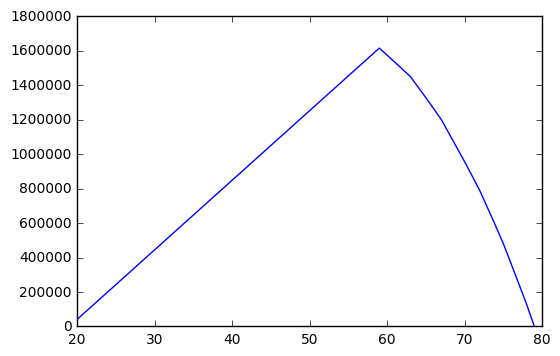

In [10]:
P_K = P_K.astype('int')
A_K = asset_grid[P_K]

# Setting dead households to missing
A_K[S == 3] = np.nan

# Taking averages, skipping missing households
A_avg = np.nanmean(A_K, axis = 1)

# Plotting average wealth over lifecycle for living households
%matplotlib inline

import matplotlib.pyplot as plt
plt.plot(range(20, T+20), A_avg)

We see above that our graph looks pretty similar to what we got in 